<a href="https://colab.research.google.com/github/sjccc-z/lstm-oil/blob/main/Multivariate_Oil_Price_Prediction_Using_LSTM_%26_GRU_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Title : Multivariate Analysis & Oil Price Prediction Using GRU & LSTM**

**Problem Type** : Multivariate Forecasting

**Actionable Decision :** Whether to Invest or Not in the Commodity

Importing and installing libraries

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
from scipy.stats import zscore as zs
from scipy import linalg as scipy_linalg
from sklearn.model_selection import train_test_split as split
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)
from google.colab import files
from keras.optimizers import SGD
from IPython.display import display, Image


In [107]:
##Matplotlib Parameters
import matplotlib.ticker as ticker
from pylab import rcParams
rcParams['axes.labelsize'] = 12
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
plt.style.context('fivethirtyeight')

In [108]:
##Installing Tensorflow-GPU
%%capture
!pip install tensorflow-gpu

In [109]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [110]:
file_path = '/content/drive/MyDrive/COMBINED.csv'
oil_df = pd.read_csv(file_path)
oil_df.head(2)

,Date,WTI,GOLD,SP 500,US DOLLAR INDEX,US 10YR BOND,DJU
0,04-01-2000,25.55,282.7,1411.75,100.10,6.499,289.10
1,05-01-2000,24.91,281.1,1413.50,100.05,6.599,292.64


# **Data Description :-**

**Source of Data Collection**:Individual Data series collected from (https://in.investing.com/) between 4th Jan 2000 to 10th June 2019.

**Data Dimentions :-**

-> 4947 Attributes

-> 7 Features

-------------------------
**Date**: Date of Trading

**WTI** :  Includes spot values of West Texas Intermediate which is mix of crude oil traded on NYMEX.

**GOLD** : With Increase in Oil price ,inflation increases and in turn GOLD futures also increases. Gold futures is a good indicator of economic situations.

**SP 500** : Overall market
stability can be ascertained by S&P 500 as it contains 500 large companies.Can indicate market sentiments and economic conditions.

**US DOLLAR INDEX** : Represents US Dollar Index Futures . Foreign exchange market has quite an impact on oil prices since the US dollar is international metric to interpret the global economic conditions.

**US 10YR BOND** :Represents US 10-Year Bond yeild . Is a certificate of
loan with federal government that matures in 10 years. Great indicator of investor sentiment about the economy.

**DJU**:Represents Dow Jones Utility Average.
Performance of 15
important utility stocks,these being sensitive to changes in the price of commodities such as natural gas or coal.

Target Variable- (WTI)

Features -(GOLD),(SP 500),(US DOLLAR INDEX),(US 10YR BOND),(DJU)

->Since this is a time series problem and WTI will be autoregressive ,we will use it also as a feature.

Getting to Know Our Data

In [111]:
oil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4947 entries, 0 to 4946
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             4947 non-null   object 
 1   WTI              4947 non-null   float64
 2   GOLD             4941 non-null   float64
 3   SP 500           4946 non-null   float64
 4   US DOLLAR INDEX  4917 non-null   float64
 5   US 10YR BOND     4920 non-null   float64
 6   DJU              4859 non-null   float64
dtypes: float64(6), object(1)
memory usage: 270.7+ KB


During preprocessing :-

->We need to convert Date into DateTime

->Make Date column index .

In [112]:
oil_df.describe()

,WTI,GOLD,SP 500,US DOLLAR INDEX,US 10YR BOND,DJU
count,4947.000000,4941.000000,4946.000000,4917.000000,4920.000000,4859.000000
mean,62.068803,943.852311,1544.704848,90.503182,3.453490,459.169801
std,26.470270,473.656860,544.716725,11.691564,1.222532,147.334229
min,17.450000,255.100000,676.000000,71.304000,1.358000,167.570007
25%,40.115000,424.000000,1150.250000,80.946000,2.382000,359.664994
50%,59.300000,1088.500000,1356.250000,88.350000,3.389500,438.119995
75%,83.725000,1329.800000,1945.687500,96.940000,4.413000,553.309998
max,145.290000,1888.700000,2948.500000,121.210000,6.790000,812.909973


In [113]:
##Checking Missing Values
oil_df.isnull().sum()

,0
Date,0
WTI,0
GOLD,6
SP 500,1
US DOLLAR INDEX,30
US 10YR BOND,27
DJU,88


Missing Values-(Previous Day Imputation)

In [114]:
##Filling Missing Values with Previous Day Value
oil_df = oil_df.fillna(method='ffill')
oil_df.isnull().sum()

<ipython-input-114-756028127f2e>:2: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



,0
Date,0
WTI,0
GOLD,0
SP 500,0
US DOLLAR INDEX,0
US 10YR BOND,0
DJU,0


In [115]:
##Converting Date column as DateTime format
oil_df['Date'] = pd.to_datetime(oil_df['Date'],format='%d-%m-%Y')

In [116]:
oil_df.dtypes

,0
Date,datetime64[ns]
WTI,float64
GOLD,float64
SP 500,float64
US DOLLAR INDEX,float64
US 10YR BOND,float64
DJU,float64


In [117]:
##Setting Date as Index
oil_df.set_index('Date',inplace=True)

In [118]:
oil_df.head(2)

,WTI,GOLD,SP 500,US DOLLAR INDEX,US 10YR BOND,DJU
Date,,,,,,
2000-01-04,25.55,282.7,1411.75,100.10,6.499,289.10
2000-01-05,24.91,281.1,1413.50,100.05,6.599,292.64


# Exploratory Data Analysis(EDA)

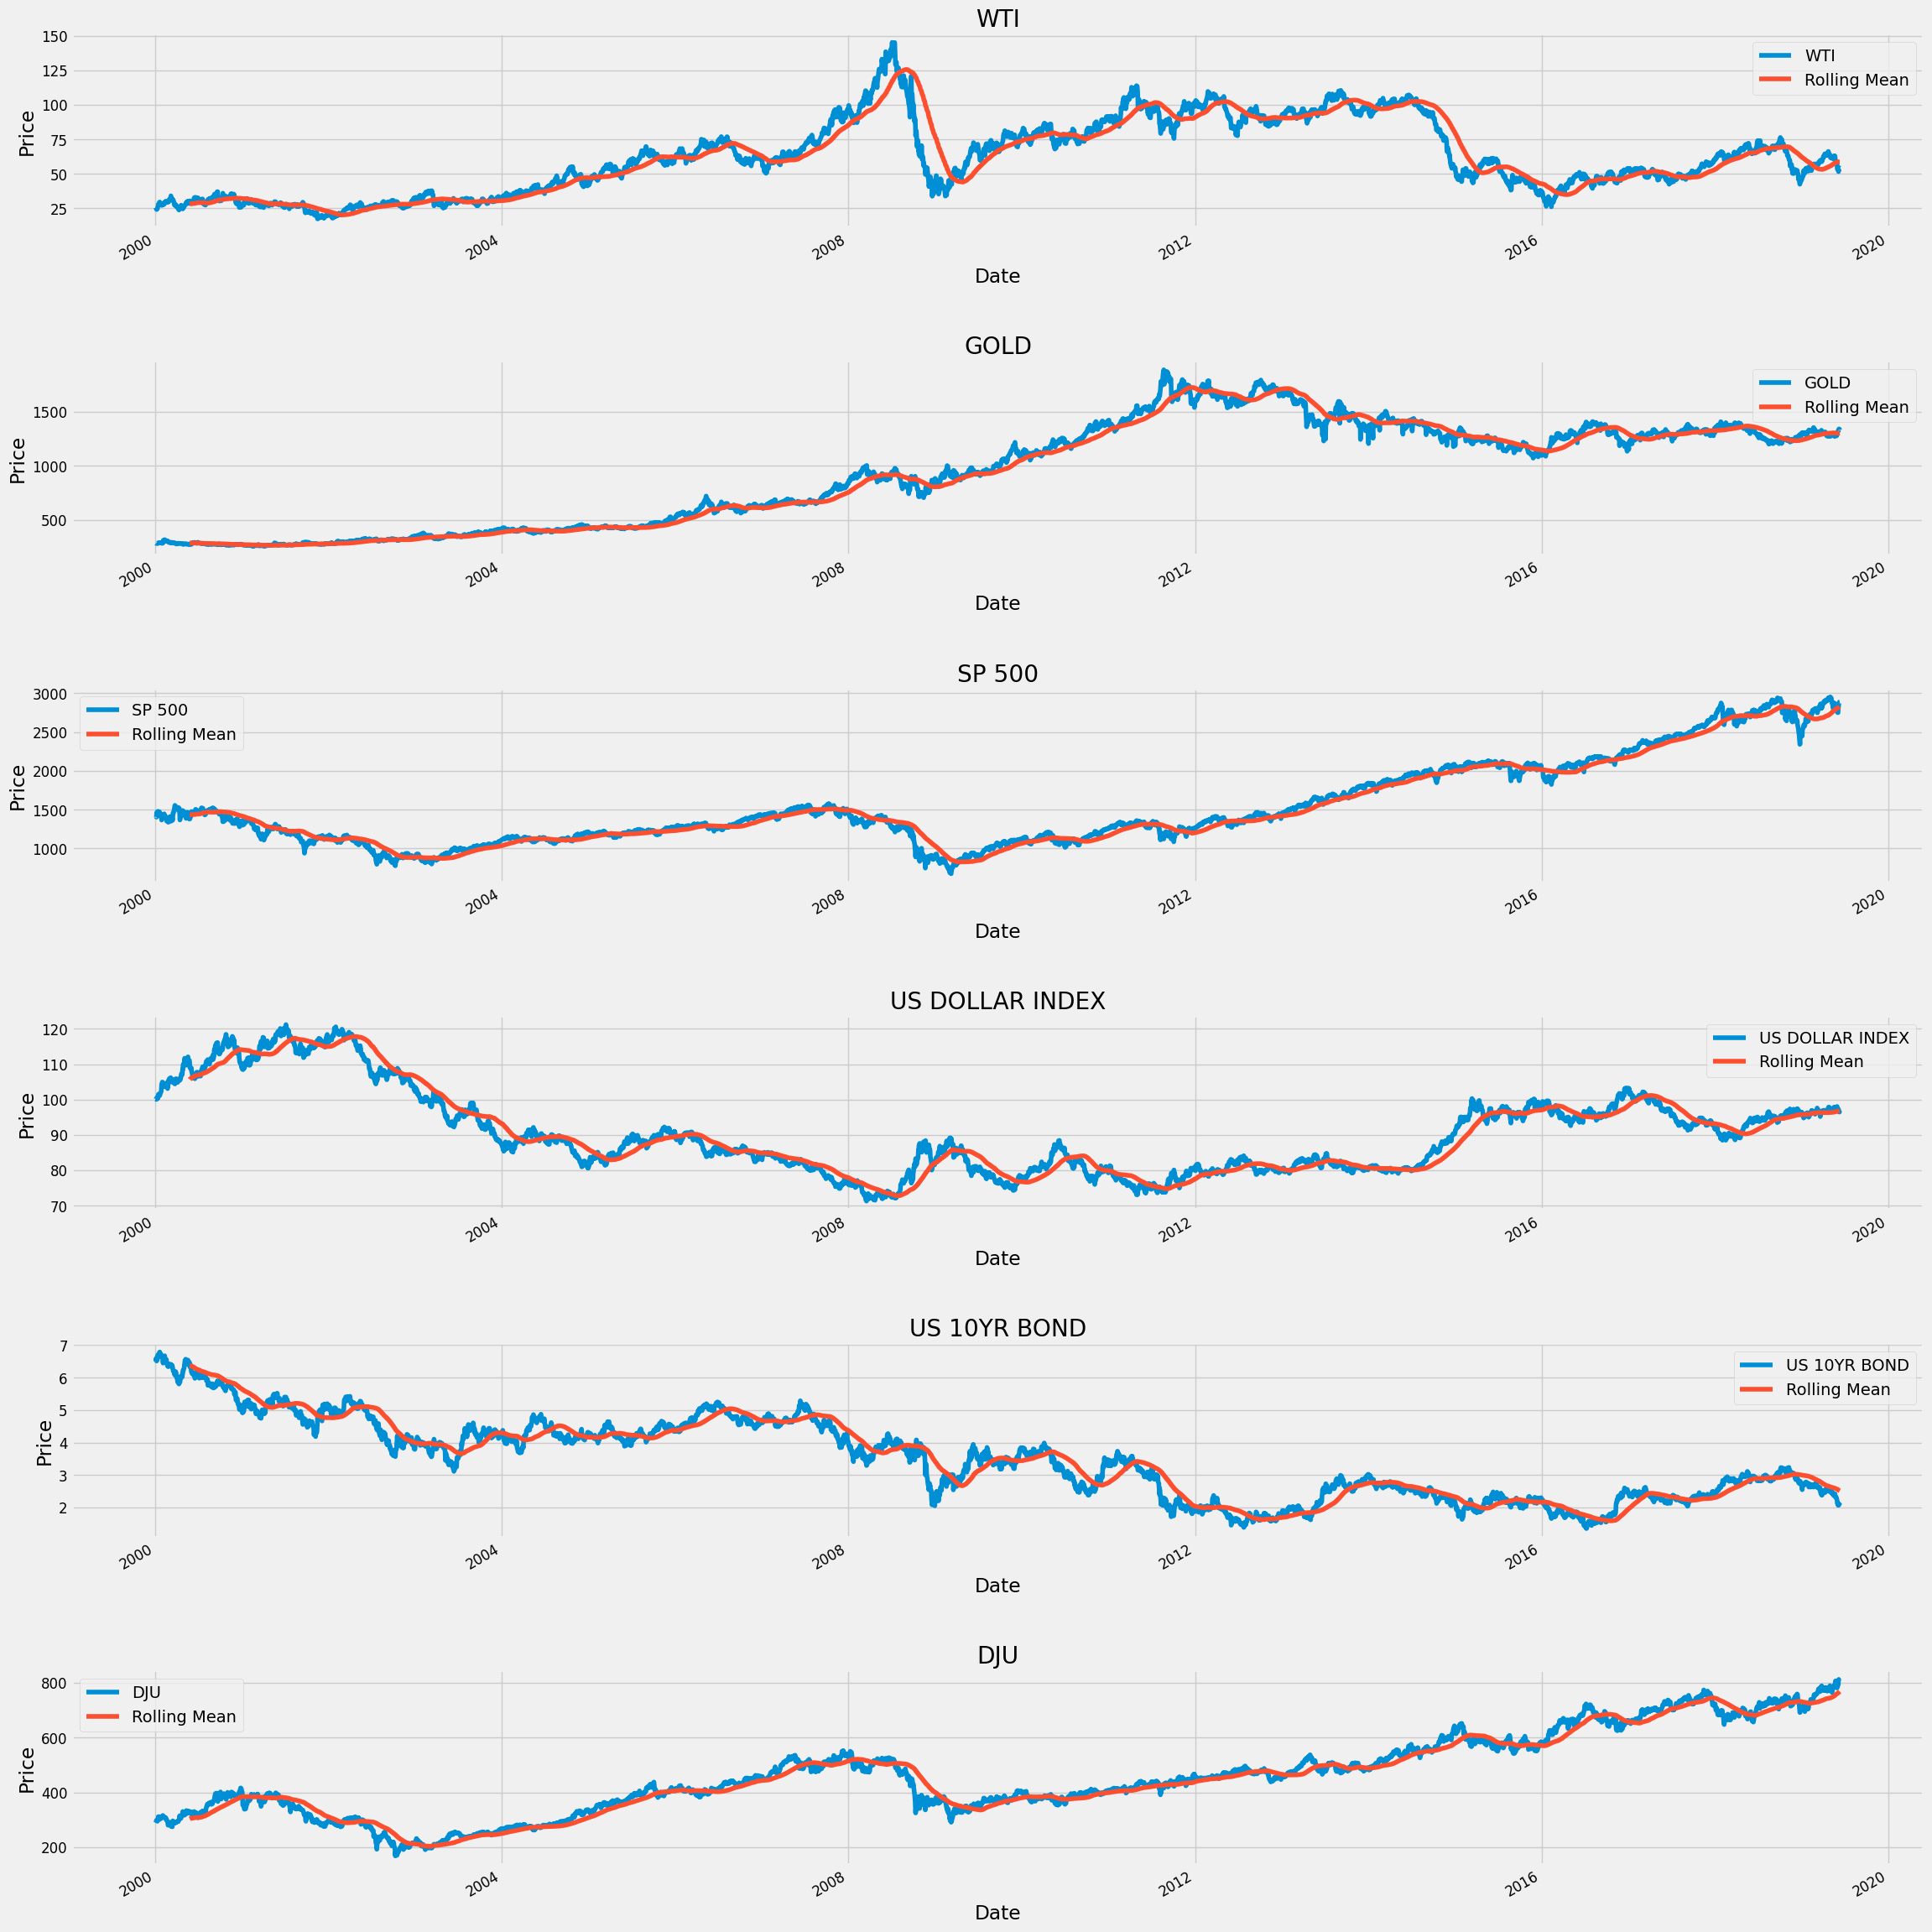

In [119]:
##Line Plots Target & Features
data = oil_df
col_names = data.columns

fig = plt.figure(figsize=(24, 24))
plt.style.use('fivethirtyeight')
for i in range(6):
  ax = fig.add_subplot(6,1,i+1)
  ax.plot(data.iloc[:,i],label=col_names[i])
  data.iloc[:,i].rolling(100).mean().plot(label='Rolling Mean')
  ax.set_title(col_names[i])
  ax.set_xlabel('Date')
  ax.set_ylabel('Price')
  plt.legend()
fig.tight_layout(pad=3.0)
plt.show()

Inferences :-

-> WTI has mix of both UP and DOWN trends.

-> Gold, DJU has UP Trend.

-> US Dollar Index, US 10YR Bond has downward trend.


<ipython-input-120-a8859130ad2a>:8: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-120-a8859130ad2a>:8: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-120-a8859130ad2a>:8: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use

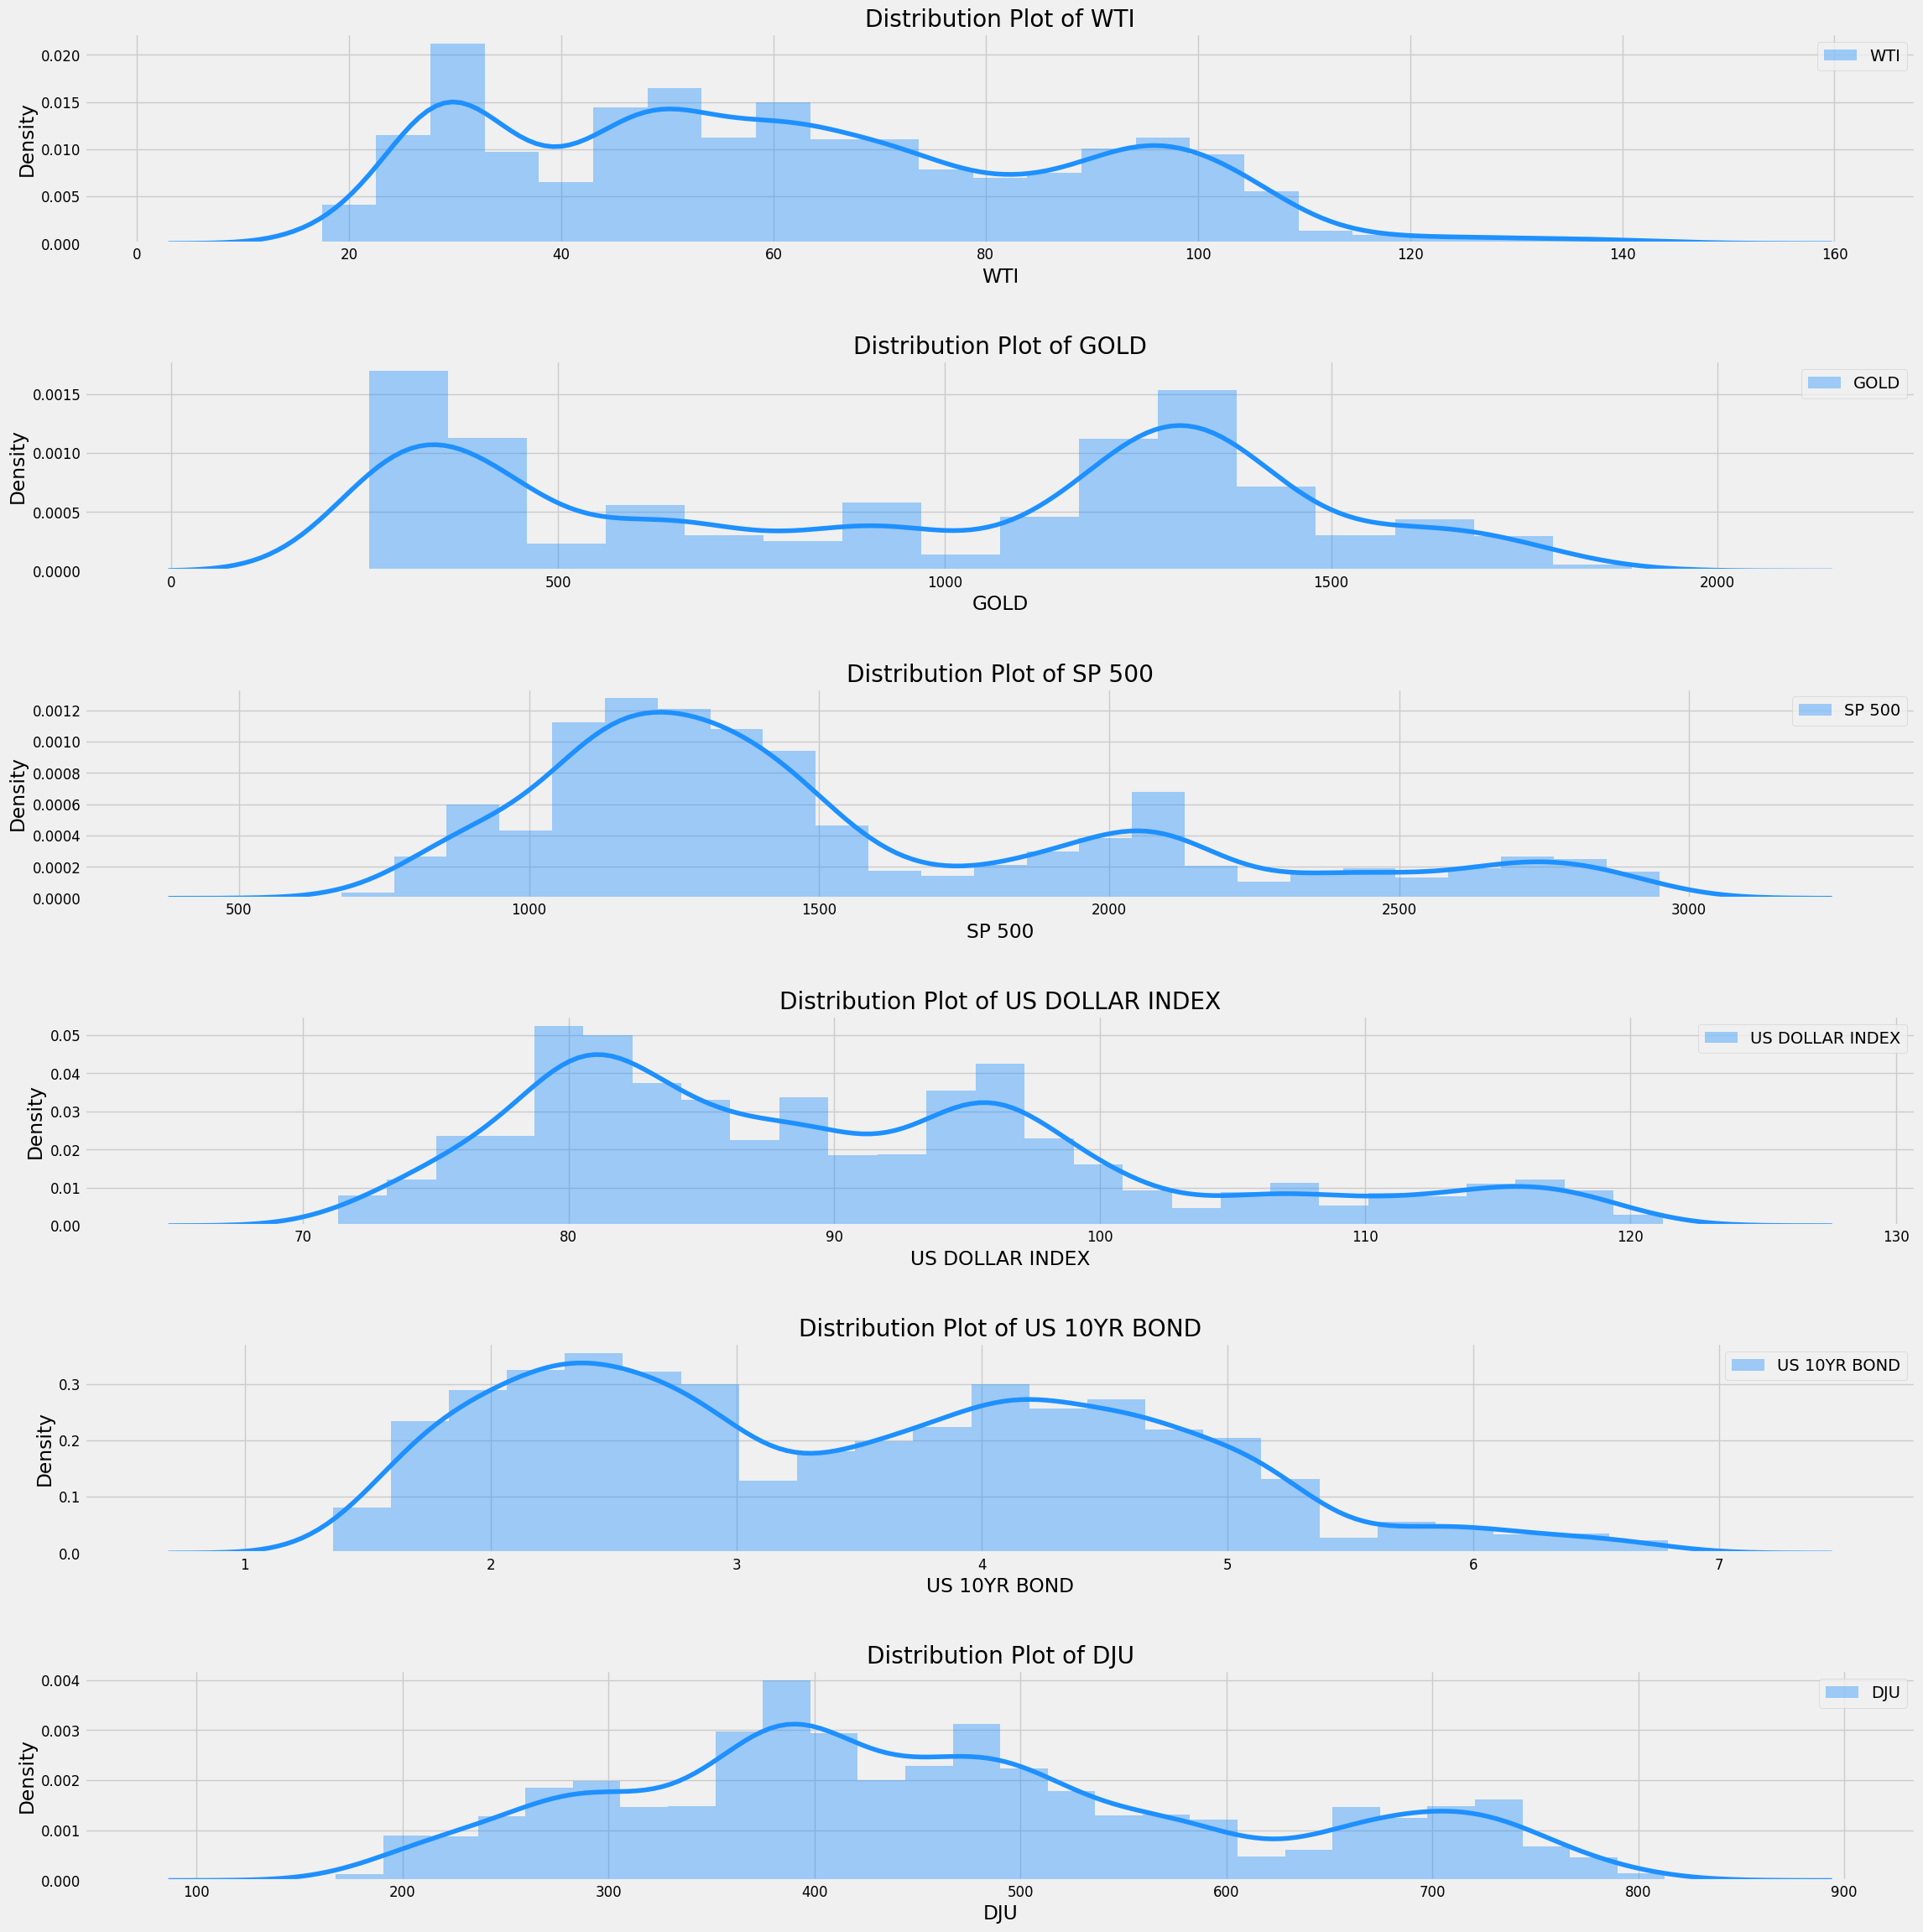

In [120]:
##Checking if Target and Features follow Normal Distribution
data = oil_df
fig = plt.figure(figsize=(24, 24))
plt.style.use('fivethirtyeight')
col_names = data.columns
for i in range(6):
  ax = fig.add_subplot(6,1,i+1)
  sns.distplot(data.iloc[:,i],label=col_names[i],color='dodgerblue').set_title("Distribution Plot of {}".format(col_names[i]),axes=ax)
  ax.tick_params(labelsize=12)
  plt.legend()
fig.tight_layout(pad=3.0)
plt.show()


From above Distribution plots :-

-> Most frequent values of WTI are in the range of 25 to 35.

-> The WTI oil price values above 120
are less frequent.

-> All Features & WTI don't follow Normal Distribution.

In [121]:
## Temporary DataFrame
temp_data = oil_df
temp_data['Year'] = oil_df.index.year

Text(0.5, 1.0, 'Box Plot Year Wise-WTI')

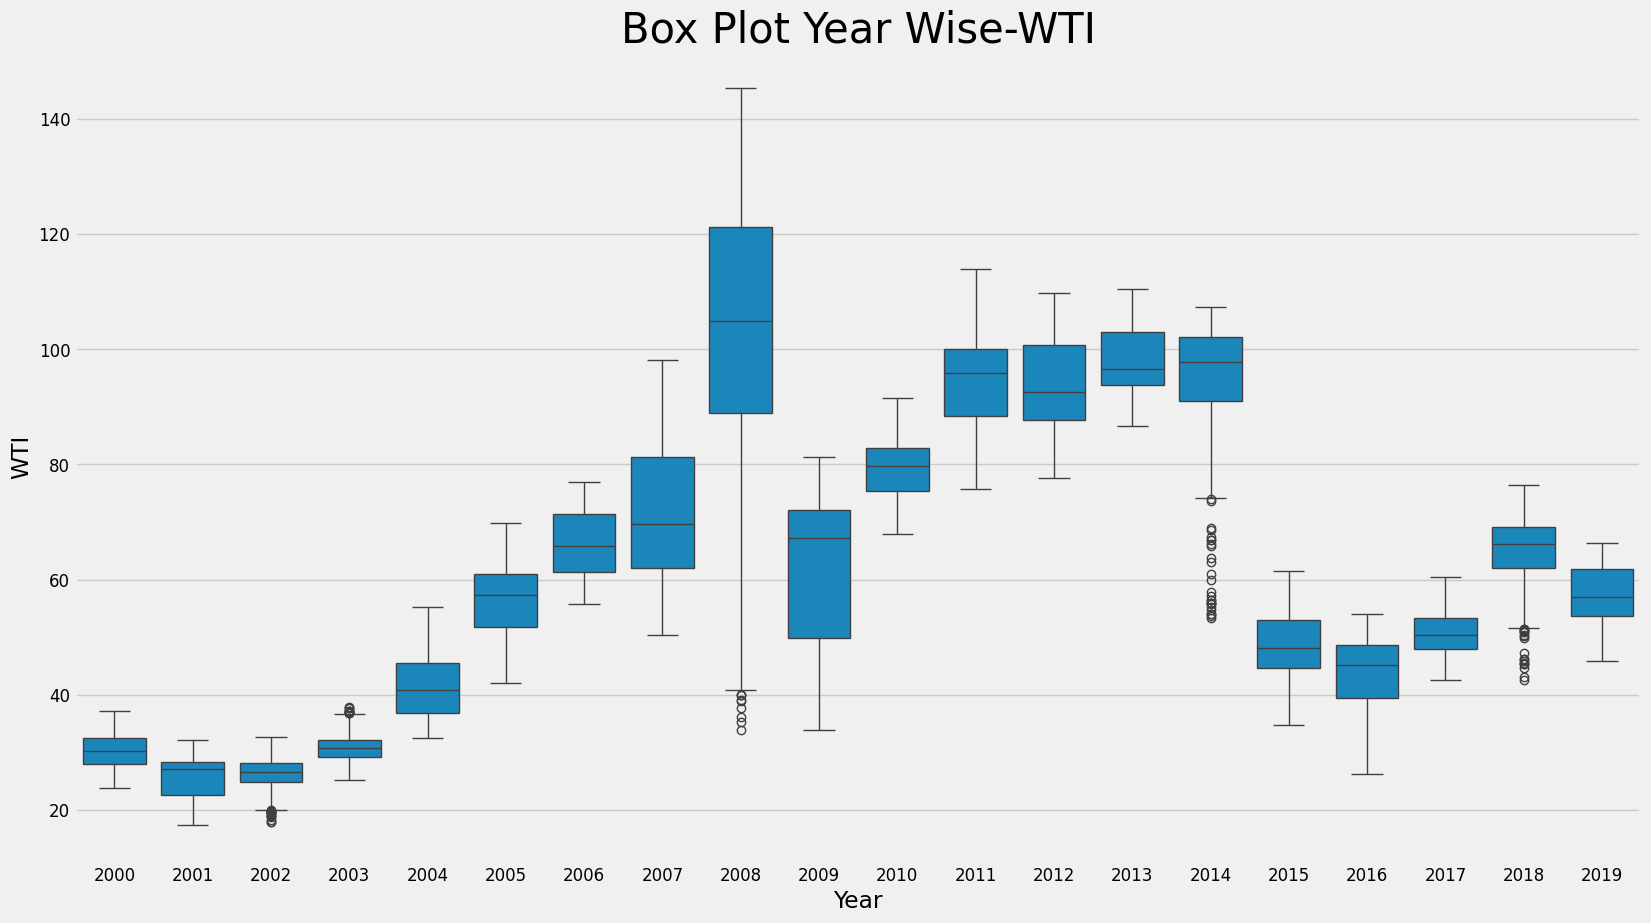

In [122]:
##Box Plot Year Wise WTI
plt.figure(figsize=(18,10))
ax = sns.boxplot(x=temp_data['Year'], y=temp_data['WTI'])
ax.set_title('Box Plot Year Wise-WTI',fontsize=30)

-> During the years 2007, 2008, and 2009 wide variations in the values of WTI have been
observed.

-> In the year 2008, which is the period of the financial crisis and huge volatality, the
WTI oil price varies between 30-140$.

-> Years 2002, 2008, 2014 & 2018 show outliers.


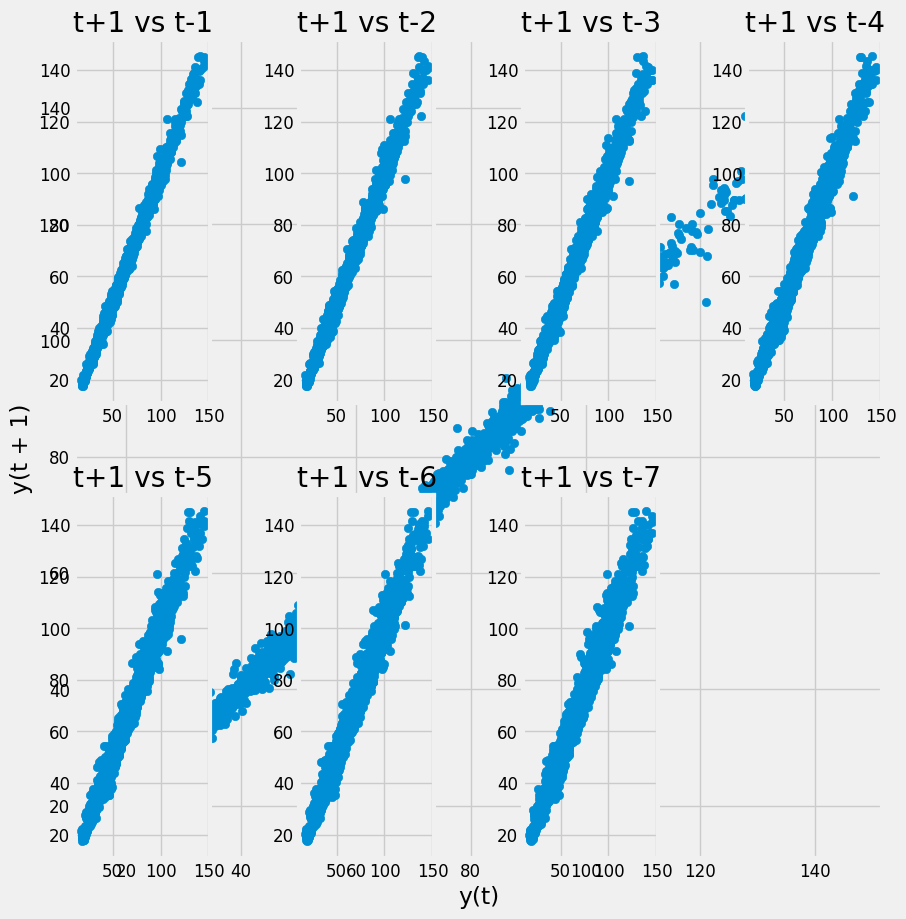

In [123]:
##Checking Series Lag Relationship(Auto-Correlation Nature)
##Citing Source-(https://machinelearningmastery.com/time-series-data-visualization-with-python/)
plt.figure(figsize=(10,10))
pd.plotting.lag_plot(oil_df['WTI'])
wti_series = oil_df['WTI']
n_lags = 7
cols = [wti_series]

for i in range(1,(n_lags + 1)):
	cols.append(wti_series.shift(i))
df = pd.concat(cols, axis=1)
cols = ['t+1']
for i in range(1,(n_lags + 1)):
	cols.append('t-' + str(i))
df.columns = cols
plt.figure(1)
for i in range(1,(n_lags + 1)):
	ax = plt.subplot(240 + i)
	ax.set_title('t+1 vs t-' + str(i))
	plt.scatter(x=df['t+1'].values, y=df['t-'+str(i)].values)
plt.tight_layout(pad=2)
plt.show()

-> The above Lag plot indicates that WTI has good positive correlation with each of its lagging orders.

-> This kind of series is good for time series as its showing auto-regressive nature.

**Bivariate Analysis (WTI and Features)**

In [124]:
oil_df.drop(labels=['Year'],axis=1,inplace=True)

In [125]:
##Scaling Data to Observe Bivariate Analysis
sc = MinMaxScaler(feature_range=(0,1))
oil_df_scaled= sc.fit_transform(oil_df)

Since distribution is not normal we use Standardisation instead of Normalization.

In [126]:
##Scaled Data Glimse
oil_df_scaled[:2]

array([[0.06336045, 0.0168952 , 0.32376238, 0.57700477, 0.94642857,
        0.18831933],
       [0.05835419, 0.01591577, 0.32453245, 0.57600289, 0.964838  ,
        0.19380482]])

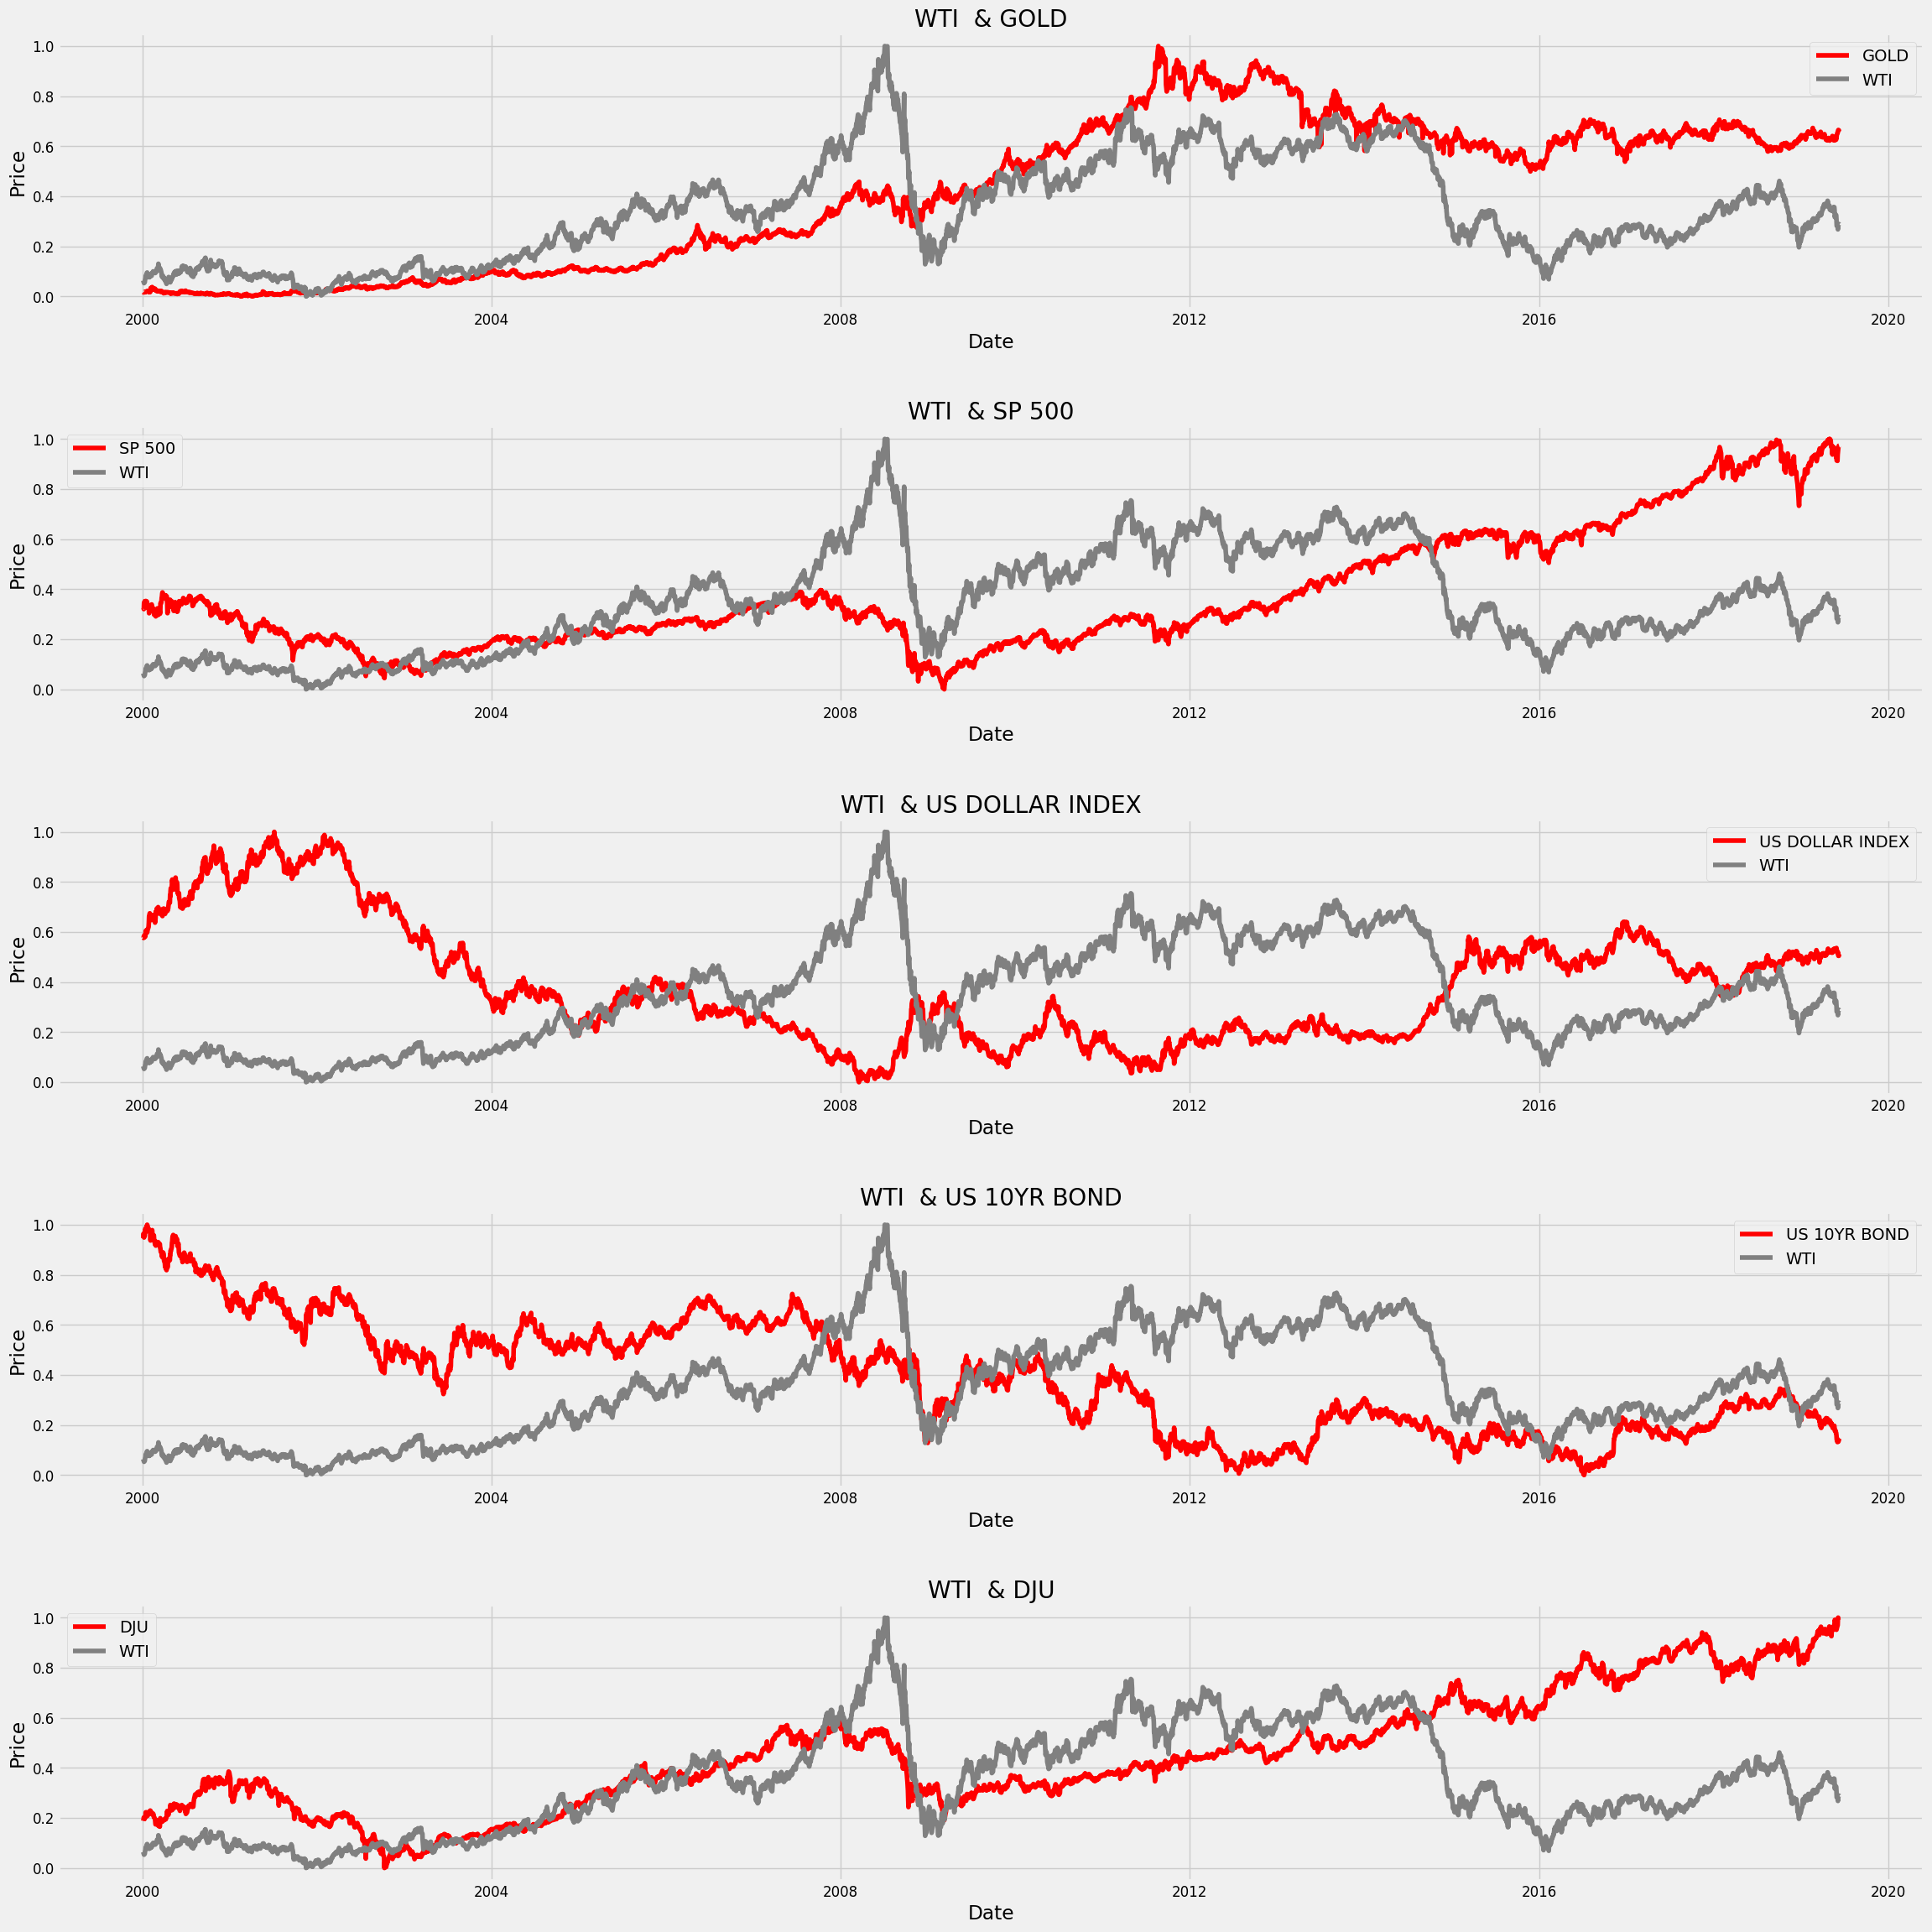

In [127]:
##Comparing Movement of WTI wrt to Features
col_names = data.columns[1:]
scaled_features = oil_df_scaled[:,1:]
fig = plt.figure(figsize=(24, 24))
plt.style.use('fivethirtyeight')
for i in range(5):
  ax = fig.add_subplot(5,1,i+1)
  ax.plot(oil_df.index,scaled_features[:,i],label=col_names[i],c='red')
  ax.plot(oil_df.index,oil_df_scaled[:,0],label='WTI',c='grey')
  ax.set_title('WTI  & ' + col_names[i])
  ax.set_xlabel('Date')
  ax.set_ylabel('Price')
  plt.legend()
fig.tight_layout(pad=3.0)
plt.show()

Inferences From Bivariate Feature Analysis :-

->During 2009 the value for both WTI and SP 500 drop sharply indicating that both these series are affected by same external factors. Move together.


->US Dollar index coinciding at several points
with WTI, meaning that both the variables are strongly correlated. Apart from some common
points the relationship seems to be inverse specifically when observing periods of 2000, 2007-
09 and 2010-16. Don't Move together.


->Both WTI and gold are fluctuating together.
The gold seems to be lagging to the WTI in some ways especially if we observe years 2007
wherein gold has not had much difference as WTI. Move together.

->US 10 year bond interest rates seem
to be a leading indicator to volatility of WTI price, as we can see specifically from 2000-09 US
bond progresses downward and then the WTI follows it. The US interest rate basically gave us
a leading indication to financial crisis is what we have observed. Don't Move together.

-> DJU & WTI move together.Very High correlation between 2003-2009.


**Multivariate Analysis**

In [128]:
fig = px.parallel_coordinates(oil_df,color='WTI',color_continuous_scale=px.colors.diverging.Tealrose,
                              title='Parallel Co-ordinates Plot')

fig.show()

In [129]:
##To display on Github Viewer
##display(Image(filename='/content/drive/MyDrive/GitHub Projects/LSTM Oil Price/parallel plots img.png'))

Inferences From Parallel Co-ordinates Plot :-

->The higher values of WTI correpond to average values for GOLD,US 10 YR BOND,DJU. (Red shaded Path)

->Low Values of WTI correspond to High Values of US Dollar Index(Dark Green Shaded Path).


Since Target & Feature don't follow normal distribution , we will use
**Spearman Correlation**.


**HeatMap**

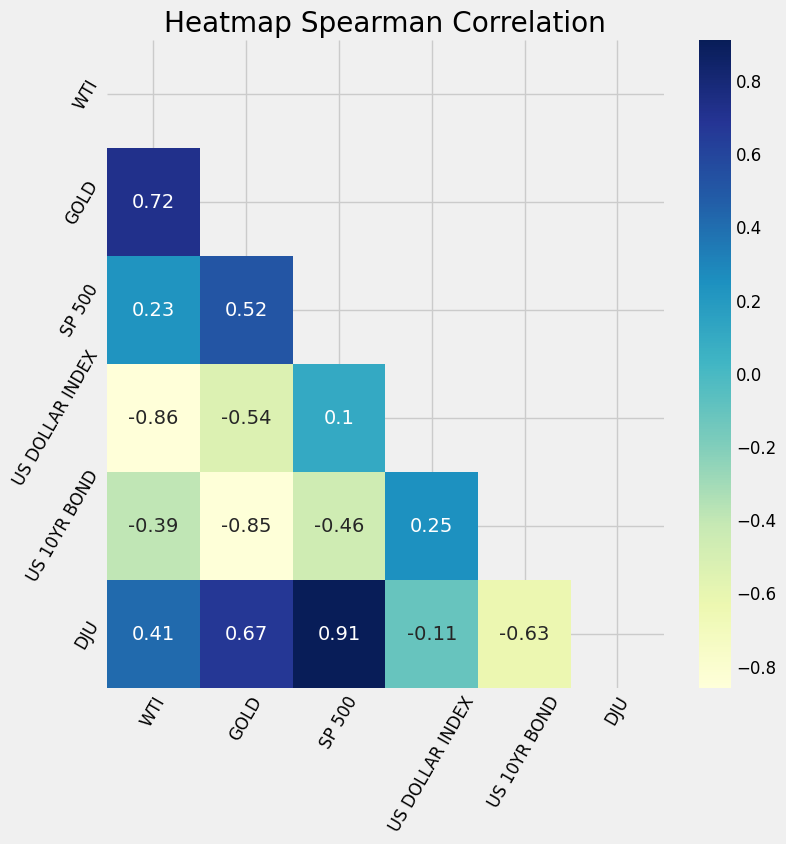

In [130]:
##HeatMap Spearman Correlation
plt.figure(figsize=(8,8))
matrix = np.triu(oil_df.corr(method='spearman'))
heat_map = sns.heatmap(oil_df.corr(method='spearman'),annot=True,annot_kws={"size":14},cmap= 'YlGnBu',mask=matrix)
heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=60)
heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=60)
plt.tick_params(labelsize=12)
plt.title('Heatmap Spearman Correlation')
plt.style.use('fivethirtyeight')

-> The highest positive correlation with target variable WTI is with Gold(ρ:0.72)

-> We also observe that SP500 and WTI have less correlation.(ρ : 0.23)

-> US 10 YR Bond and WTI are moderately inversely correlated.(ρ : -0.39)

-> DJU & WTI positive moderate correlation.(ρ : 0.41 )

-> US Dollar Index & WTI have high correlation .(ρ : -0.86)

-> We observe high correlation between DJU & SP 500 (ρ : 0.91)
observed the SP 500 and DJU also have very high positive correlation.This is kind of Expected since both are indexes.


In [131]:
##Spearman Correlation In Tabular Form
oil_df.corr(method='spearman')

,WTI,GOLD,SP 500,US DOLLAR INDEX,US 10YR BOND,DJU
WTI,1.000000,0.720076,0.230186,-0.859079,-0.390108,0.413496
GOLD,0.720076,1.000000,0.515117,-0.537962,-0.846502,0.669786
SP 500,0.230186,0.515117,1.000000,0.104122,-0.460171,0.910919
US DOLLAR INDEX,-0.859079,-0.537962,0.104122,1.000000,0.245306,-0.111127
US 10YR BOND,-0.390108,-0.846502,-0.460171,0.245306,1.000000,-0.626274
DJU,0.413496,0.669786,0.910919,-0.111127,-0.626274,1.000000


# Feature Selection
We eliminate features by Filteration technique and use correlation factor .
->We eliminate all features having spearman correlation less than magnitude of
0.4.  
->We remove SP 500 and US 10 YR Bond ,we also thereby eliminate Multicollinearity present among (SP 500 & DJU),(US 10 YR BOND & DJU),(GOLD & DJU).

Features remaining : WTI ,GOLD , US DOLLAR INDEX.
Since this is time series problem even WTI will be included as a feature as it is a autoregressive problem.

In [132]:
##Feature Selection
after_fs = oil_df[['WTI','GOLD','US DOLLAR INDEX']]
after_fs.head(3)

,WTI,GOLD,US DOLLAR INDEX
Date,,,
2000-01-04,25.55,282.7,100.10
2000-01-05,24.91,281.1,100.05
2000-01-06,24.78,281.4,100.34


# **Outlier Elimination**

**(Method-1) Financial Crisis Outlier Removal (2007-2009)**

We observed financial crisis from 2007 to 2009.
We remove data points from mid of 2007 to mid of 2019 as this was a big crisis and led to lot of volatality of oil price movement as observed earlier.
We eliminated 482 outliers.

In [133]:
before_2007 = after_fs['2000-01':'2007-06']
after_2009 = after_fs['2009-06':'2019-06']
fin_out = pd.concat([before_2007,after_2009],axis=0)
fin_out.shape

(4465, 3)

**(Method-2) Z-Score Outlier Removal Technique**

We can use Z-scores to detect outliers by calculating how many standard deviations away is a point from the mean.

In [134]:
zscore = np.abs(zs(after_fs['WTI']))
zscore_df = after_fs.copy()
zscore_df['zscore'] = zscore
zscore_df.head(5)

,WTI,GOLD,US DOLLAR INDEX,zscore
Date,,,,
2000-01-04,25.55,282.7,100.10,1.379755
2000-01-05,24.91,281.1,100.05,1.403936
2000-01-06,24.78,281.4,100.34,1.408847
2000-01-07,24.22,281.9,100.50,1.430005
2000-01-10,24.67,281.7,100.65,1.413003


In [135]:
##Considering Outliers of more than +-2.5 zscore as outliers
len(zscore_df[zscore_df['zscore']>2.5])

37

In [136]:
zscore_df = zscore_df.loc[zscore_df['zscore']<2.5,['WTI','GOLD','US DOLLAR INDEX']]
zscore_df.shape

(4910, 3)

We considered all points of more than 2.5 times away from mean as outliers and removed 37 datapoints.
Z-score can be calculated on univariate series so we used it on our target variable WTI and removed corresponding points.

**(Method-3) Mahalanobis Distance Outlier Removal Technique**

Mahalanobis distance is distance between two points in a multivariate space. It can be effectively used to eliminate outliers when :-

-> There is correlation with target variable.

-> Multi-dimensional distance is possible otherwise not possible in Euclidean distance.

In [137]:
## Citing Source : https://www.machinelearningplus.com/statistics/mahalanobis-distance/
##Outlier Removal Method-3-Mahalanobis Distance
def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = scipy_linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()


In [138]:
mah_df = after_fs.copy()
mah_df['Mahalanobis'] = mahalanobis(x=mah_df, data=mah_df)
mah_df.head(3)

,WTI,GOLD,US DOLLAR INDEX,Mahalanobis
Date,,,,
2000-01-04,25.55,282.7,100.10,3791.532794
2000-01-05,24.91,281.1,100.05,3797.672788
2000-01-06,24.78,281.4,100.34,3793.602982


<ipython-input-139-1550048091a2>:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='Mahalanobis', ylabel='Density'>

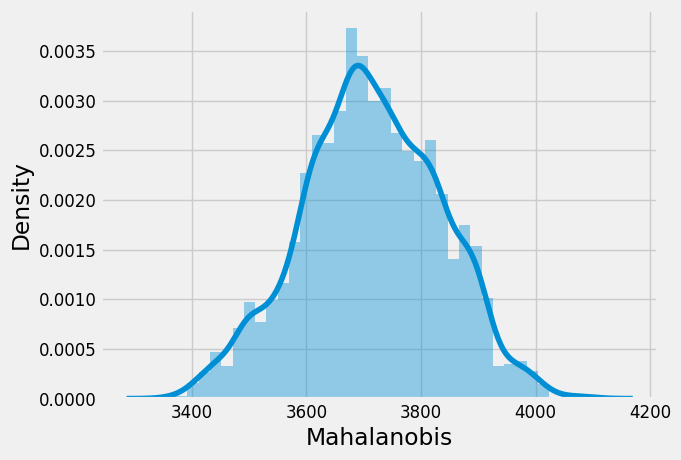

In [139]:
sns.distplot(mah_df['Mahalanobis'])

In [140]:
##We consider points with Mahalanobis distance greater than 8 to be outliers.
len(mah_df[mah_df['Mahalanobis']>8])

4947

We removed 145 datapoints by using Mahalanobis distance.

In [141]:
mah_df = mah_df.loc[mah_df['Mahalanobis']<8,['WTI','GOLD','US DOLLAR INDEX']]

# Data Preparation for Modelling

**Train-Test Split**

In [142]:
fin_train,fin_test = split(fin_out,train_size=0.7,shuffle=False)
z_train,z_test = split(zscore_df,train_size=0.7,shuffle=False)
##mah_train,mah_test = split(mah_df,train_size=0.7,shuffle=False)
van_train,van_test = split(after_fs,train_size=0.7,shuffle=False)

In [143]:
print('Fin Outlier Dataset')
print(fin_train.shape)
print(fin_test.shape)
print('Zscore Dataset')
print(z_train.shape)
print(z_test.shape)
##print('Mahalanobis Dataset')
##print(mah_train.shape)
##print(mah_test.shape)
print('Vanilla Model-No Outlier Elimination')
print(van_train.shape)
print(van_test.shape)

Fin Outlier Dataset
(3125, 3)
(1340, 3)
Zscore Dataset
(3437, 3)
(1473, 3)
Vanilla Model-No Outlier Elimination
(3462, 3)
(1485, 3)


**Scaling Data for Model**

In [144]:
##We need 2 scalers per model -Train and Test require different scalers
sc1 = MinMaxScaler(feature_range=(0,1))
sc2 = MinMaxScaler(feature_range=(0,1))

We will carry out Standardisation after train-test split to prevent overfitting.

LSTM /GRU stores data by taking in number of  timesteps for 1 output. So suppose we give 60 timesteps , that means for 61st day the model considers 1-60 days for sequence and so on.


In [145]:
##Function to Prepare Training Data for LSTM
def prepare_train_data_lstm(scaler,train_data,n_dim):
  input_data = scaler.fit_transform(train_data.values)
  print('Shape of Input Data Initially',input_data.shape)
  timesteps = 60
  global X1
  X1 = []
  global y1
  y1=[]
  for i in range(len(input_data)-timesteps-1):
    t=[]
    for j in range(0,timesteps):

        t.append(input_data[[(i+j)], :])
    X1.append(t)
    y1.append(input_data[i+ timesteps,0])

  X1, y1= np.array(X1), np.array(y1)
  print('Shape of Train Part after transformation',X1.shape)
  print('Shape of Test Part after transformation ',y1.shape)

  X1 = X1.reshape(X1.shape[0],timesteps, n_dim)
  print('Final Shape ',X1.shape)
  return X1,y1

In [158]:
##LSTM Model Function
def lstm_model(scaler,train_data,n_dim):
#initialize model
  prepare_train_data_lstm(scaler,train_data,n_dim)

  global model
  model = Sequential()

#layer 1 of LSTM
  model.add(LSTM(units=30,return_sequences=True,input_shape=(X1.shape[1],n_dim)))
  model.add(Dropout(0.2))

#layer 2 of LSTM
  model.add(LSTM(units=30,return_sequences=True))
  model.add(Dropout(0.2))

#layer 3 of LSTM
  model.add(LSTM(units=30,return_sequences=True))
  model.add(Dropout(0.2))

#layer 4 of LSTM
  model.add(LSTM(units=30))
  model.add(Dropout(0.2))

#Output layer of model
  model.add(Dense(units=1))

  optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
#compiling the model
  model.compile(optimizer=optimizer,loss='mean_squared_error')
  model.fit(X1, y1, epochs=50, batch_size=32)

In [147]:
##Function to Prepare Test Data
def prepare_test_data_lstm(scaler,test_data,n_dim):
  inputs = scaler.transform(test_data.values)
  global X_test
  X_test = []
  timesteps = 60
  for i in range(len(inputs)-timesteps-1):
      t=[]
      for j in range(0,timesteps):

          t.append(inputs[[(i+j)], :])
      X_test.append(t)
  X_test = np.array(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], n_dim))
  print('Shape of Test Dataset',X_test.shape)

In [148]:
##Function to Predict Data
def predict_data(model_name,scaler_pred,test_data,X_test,Outlier_method,n_dim):

  pred = model_name.predict(X_test)
  print(len(test_data[61:]))
  set_scale = scaler_pred.fit_transform(test_data.iloc[61:,0].values.reshape(-1,1))
  pred_descale = scaler_pred.inverse_transform(pred)
  global pred_df
  pred_df = pd.DataFrame(pred_descale,columns=['Predicted -'+str(Outlier_method)])
  return pred_df

In [149]:
##Function to Calculate Result Metrics
def result_metrics_forecast(test_series,forecast_series,model_name,out_name):
  print('Result Metrics for ' +  str(model_name) + ' -{} Outlier Removal Technique'.format(out_name))
  print('R2 Score : ',round(r2_score(test_series,forecast_series),3))
  print('Mean Squared Error : ',round(mean_squared_error(test_series,forecast_series),3))
  print('Mean Absolute Error : ',round(mean_absolute_error(test_series,forecast_series),3))
  fig = plt.figure(figsize=(10,10))
  plt.plot(test_series.index,test_series,label='Actual')
  plt.plot(test_series.index,forecast_series,label='Predicted')
  plt.title(str(model_name) + ' -Forecasting Using {} Outlier Removal Technique'.format(out_name))
  plt.ylabel('Price')
  plt.legend()

# Hyper-parameter Tuning Learning Rate

In [150]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'loss',patience = 20)
X1,y1 = prepare_train_data_lstm(sc1,fin_train,3)

Shape of Input Data Initially (3125, 3)
Shape of Train Part after transformation (3064, 60, 1, 3)
Shape of Test Part after transformation  (3064,)
Final Shape  (3064, 60, 3)


In [151]:
"""
About this model : -
3 Layers of LSTM
1 Hidden Layer
Output Layer- learning rate is being optimized
Optimizer function is Adam
"""
import tensorflow as tf

## 4 layers of LSTM Model
model_simple = Sequential()

#layer 1 of LSTM
model_simple.add(LSTM(units=64,return_sequences=True,input_shape=(X1.shape[1],3)))
model_simple.add(Dropout(0.2))

#layer 2 of LSTM
model_simple.add(LSTM(units=32,return_sequences=True,input_shape=(X1.shape[1],3)))
model_simple.add(Dropout(0.2))

#layer 3 of LSTM
model_simple.add(LSTM(units=32,return_sequences=True,input_shape=(X1.shape[1],3)))
model_simple.add(Dropout(0.2))

#layer 4 of LSTM
model_simple.add(LSTM(units=16,input_shape=(X1.shape[1],3)))
model_simple.add(Dropout(0.2))

##Hidden Layer
model_simple.add(Dense(units=16))
#Output layer of model
model_simple.add(Dense(units=1))


#compiling the model
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 10))
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-8)
model_simple.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

##Model Fit
history_simple = model_simple.fit(X1, y1, epochs=200, batch_size=32,callbacks=[lr_schedule],validation_split=0.3,shuffle=False)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0280 - mae: 0.1827 - val_loss: 0.4347 - val_mae: 0.9291 - learning_rate: 1.0000e-08
Epoch 2/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0280 - mae: 0.1825 - val_loss: 0.4346 - val_mae: 0.9291 - learning_rate: 1.2589e-08
Epoch 3/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0279 - mae: 0.1821 - val_loss: 0.4346 - val_mae: 0.9290 - learning_rate: 1.5849e-08
Epoch 4/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0280 - mae: 0.1824 - val_loss: 0.4345 - val_mae: 0.9289 - learning_rate: 1.9953e-08
Epoch 5/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0278 - mae: 0.1811 - val_loss: 0.4344 - val_mae: 0.9288 - learning_rate: 2.5119e-08
Epoch 6/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0278 - mae: 0.1811 - val_loss: 0.4342 - val_mae: 0.9286 - learning_rate: 3.1623e-08
Epoch 7/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0280 - mae: 0.1826 - val_loss: 0.4341 - val_mae: 0.9285 - lear

Text(0.5, 1.0, 'Learning Rate vs Loss')

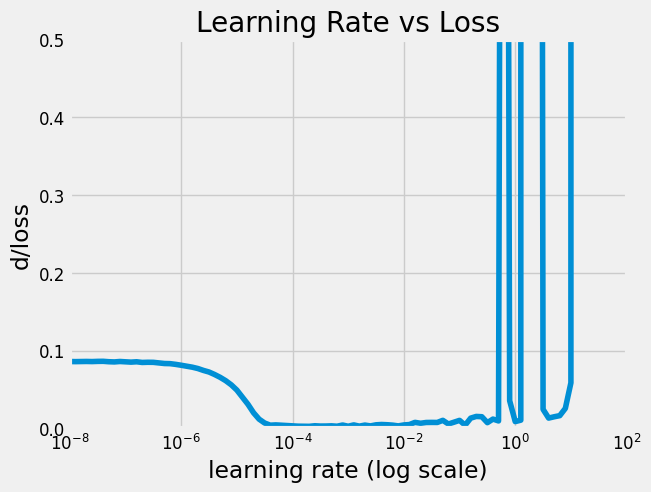

In [152]:
plt.semilogx(history_simple.history["learning_rate"], history_simple.history["loss"])
plt.axis([1e-8, 100, 0, 60])
plt.ylim(0,0.5)
plt.ylabel("d/loss")
plt.xlabel("learning rate (log scale)")
plt.title('Learning Rate vs Loss')

(1e-05, 100)

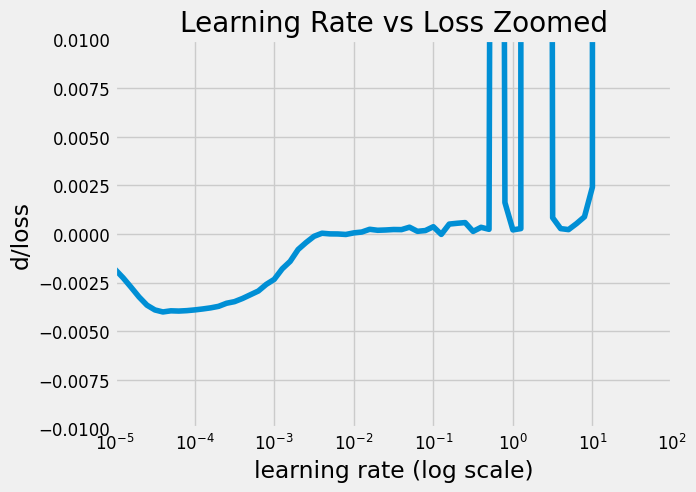

In [153]:
sma=20
n_skip=20
y_lim=(-0.01,0.01)
"""
Plots rate of change of the loss function.
    Parameters:
        sched - learning rate scheduler, an instance of LR_Finder class.
        sma - number of batches for simple moving average to smooth out the curve.
        n_skip - number of batches to skip on the left.
        y_lim - limits for the y axis.
    """
derivatives = [0] * (sma + 1)
for i in range(1 + sma,200):
  derivative = (history_simple.history["loss"][i] - history_simple.history["loss"][i - sma]) / sma
  derivatives.append(derivative)

plt.ylabel("d/loss")
plt.xlabel("learning rate (log scale)")
plt.title('Learning Rate vs Loss Zoomed')
plt.plot(history_simple.history["learning_rate"][20:], derivatives[20:])
plt.xscale('log')
plt.ylim(y_lim)
plt.xlim(1e-5,100)

Zooming in into learning rate vs Epoch graph and finind optimal learning rate for our model.

**We take the learning rate where the loss is the minimum.
The optimal learning rate looks to be around 2e-5.**

Tuning learning rate is the most important parameter .

In [154]:
##8e-4 is the optimal learning rate.
## 4 layers of LSTM Model
model_simple = Sequential()
#layer 1 of LSTM
model_simple.add(LSTM(units=64,return_sequences=True,input_shape=(X1.shape[1],3)))
model_simple.add(Dropout(0.2))

#layer 2 of LSTM
model_simple.add(LSTM(units=32,return_sequences=True,input_shape=(X1.shape[1],3)))
model_simple.add(Dropout(0.2))

#layer 3 of LSTM
model_simple.add(LSTM(units=32,return_sequences=True,input_shape=(X1.shape[1],3)))
model_simple.add(Dropout(0.2))

#layer 4 of LSTM
model_simple.add(LSTM(units=16,input_shape=(X1.shape[1],3)))
model_simple.add(Dropout(0.2))

##Hidden Layer
model_simple.add(Dense(units=16))
#Output layer of model
model_simple.add(Dense(units=1))

#compiling the model

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
model_simple.compile(loss=tf.keras.losses.MSE,
              optimizer=optimizer)

history_simple = model_simple.fit(X1, y1, epochs=40, batch_size=32,validation_split=0.3,shuffle=False)

Epoch 1/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0377 - val_loss: 0.4928
Epoch 2/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0247 - val_loss: 0.4000
Epoch 3/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0184 - val_loss: 0.2976
Epoch 4/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0157 - val_loss: 0.1962
Epoch 5/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0168 - val_loss: 0.1162
Epoch 6/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0169 - val_loss: 0.0614
Epoch 7/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0131 - val_loss: 0.0287
Epoch 8/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0081 - val_loss: 0.0141
Epoch 9/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0044 - val_loss: 0.0086
Epoch 10/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0034 - val_loss: 0.0083
Epoch 11/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0030 - val_loss: 0.0086
Epoch 12/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

<Figure size 640x480 with 0 Axes>

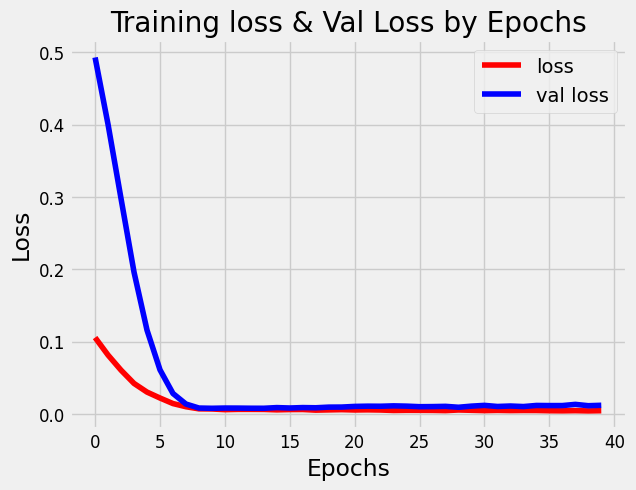

<Figure size 640x480 with 0 Axes>

In [155]:
loss=history_simple.history['loss']
val_loss = history_simple.history['val_loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r',label='loss')
plt.plot(epochs,val_loss,'blue',label='val loss')
plt.title('Training loss & Val Loss by Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.figure()

Since both training loss and validation loss are close to each other there seems to be no overfitting .
We notice smooth loss curves which is a good sign .
If there was a lot of jagginess or validation loss decreasing with increasing number of epochs we would be looking at overfitting .
In this case there appears to be no overfitting .

# Forecasting Using LSTM(Long Term Short Memory)
LSTM are type of Re-current Neural Network with 3 gates (input,output & forget).

In [159]:
##Forecasting for Financial Outlier
lstm_model(sc1,fin_train,3)

Shape of Input Data Initially (3125, 3)
Shape of Train Part after transformation (3064, 60, 1, 3)
Shape of Test Part after transformation  (3064,)
Final Shape  (3064, 60, 3)
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.3269
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.2157
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1067
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0230
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0120
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0117
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0105
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0112
Epoch 9/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0097
Epoch 10/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0104
Epoch 11/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0097
Epoch 12/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0089
Epoch 13/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0088
Epoch 14/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0094
Epoch 15/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0086
Epoch 16/50
96/

Shape of Input Data Initially (3125, 3)
Shape of Train Part after transformation (3064, 60, 1, 3)
Shape of Test Part after transformation  (3064,)
Final Shape  (3064, 60, 3)

Epoch 1/50
96/96 [==============================] - 1s 15ms/step - loss: 0.0272

Epoch 2/50
96/96 [==============================] - 1s 14ms/step - loss: 0.0064

Epoch 3/50
96/96 [==============================] - 1s 12ms/step - loss: 0.0058

Epoch 4/50
96/96 [==============================] - 1s 13ms/step - loss: 0.0050


In [160]:
prepare_test_data_lstm(sc1,fin_test,3)

Shape of Test Dataset (1279, 60, 3)


In [161]:
predict_data(model,sc2,fin_test,X_test,'Financial Outlier',3)

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
1279


,Predicted -Financial Outlier
0,88.656761
1,88.557838
2,88.446198
3,88.321526
4,88.184532
...,...
1274,59.709145
1275,59.532806
1276,59.331059
1277,59.104187


In [162]:
fin_out_pred = pred_df.copy()
fin_out_actual = fin_test.iloc[61:,0].copy()

Result Metrics for LSTM -Financial Outlier Removal Technique
R2 Score :  0.83
Mean Squared Error :  28.004
Mean Absolute Error :  4.189


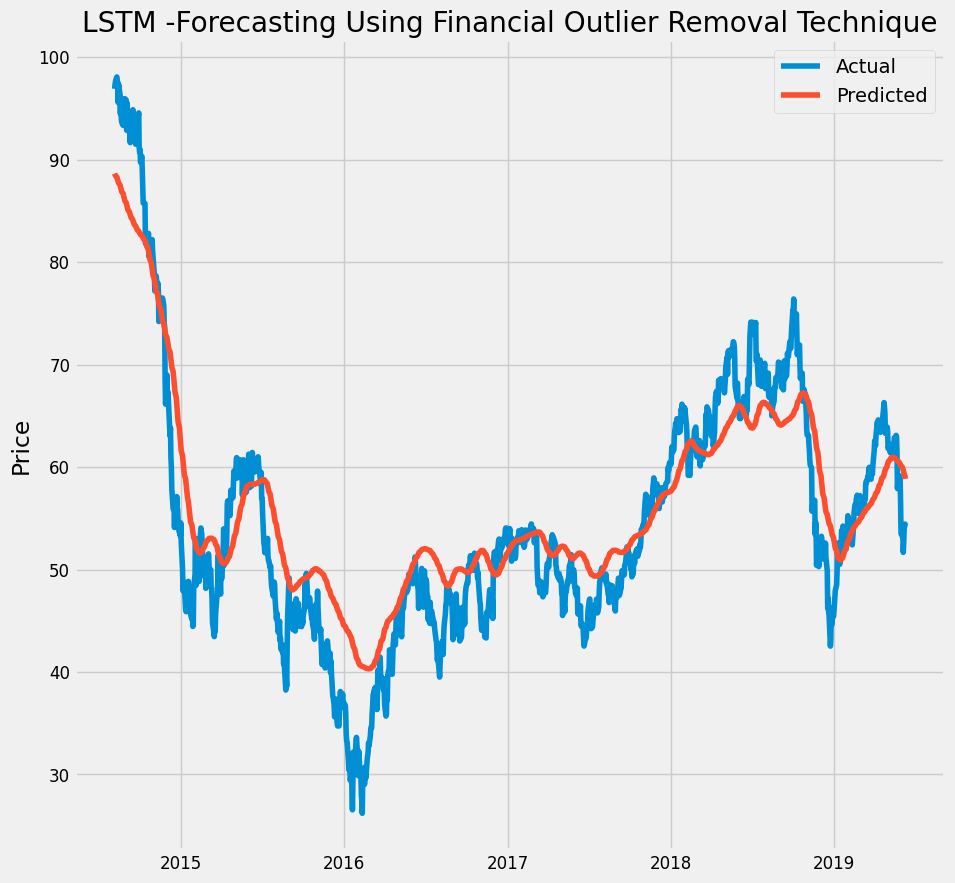

In [163]:
result_metrics_forecast(fin_out_actual,fin_out_pred,'LSTM','Financial')

In [164]:
##Forecasting For Z-Score Outlier Removed Dataset
lstm_model(sc1,z_train,3)

Shape of Input Data Initially (3437, 3)
Shape of Train Part after transformation (3376, 60, 1, 3)
Shape of Test Part after transformation  (3376,)
Final Shape  (3376, 60, 3)
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.1681
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0864
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0213
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0122
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0111
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0106
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0099
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0093
Epoch 9/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0096
Epoch 10/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0090
Epoch 11/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0087
Epoch 12/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0078
Epoch 13/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0085
Epoch 14/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0076
Epoch 15/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step 

In [165]:
prepare_test_data_lstm(sc1,z_test,3)

Shape of Test Dataset (1412, 60, 3)


In [166]:
predict_data(model,sc2,z_test,X_test,'Z-Score Outlier',3)

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
1412


,Predicted -Z-Score Outlier
0,82.003624
1,81.936440
2,81.896873
3,81.883766
4,81.893791
...,...
1407,55.087837
1408,54.926235
1409,54.740784
1410,54.531403


In [167]:
z_out_pred = pred_df.copy()
z_out_actual = z_test.iloc[61:,0].copy()

Result Metrics for LSTM -ZScore Outlier Removal Technique
R2 Score :  0.837
Mean Squared Error :  55.071
Mean Absolute Error :  5.831


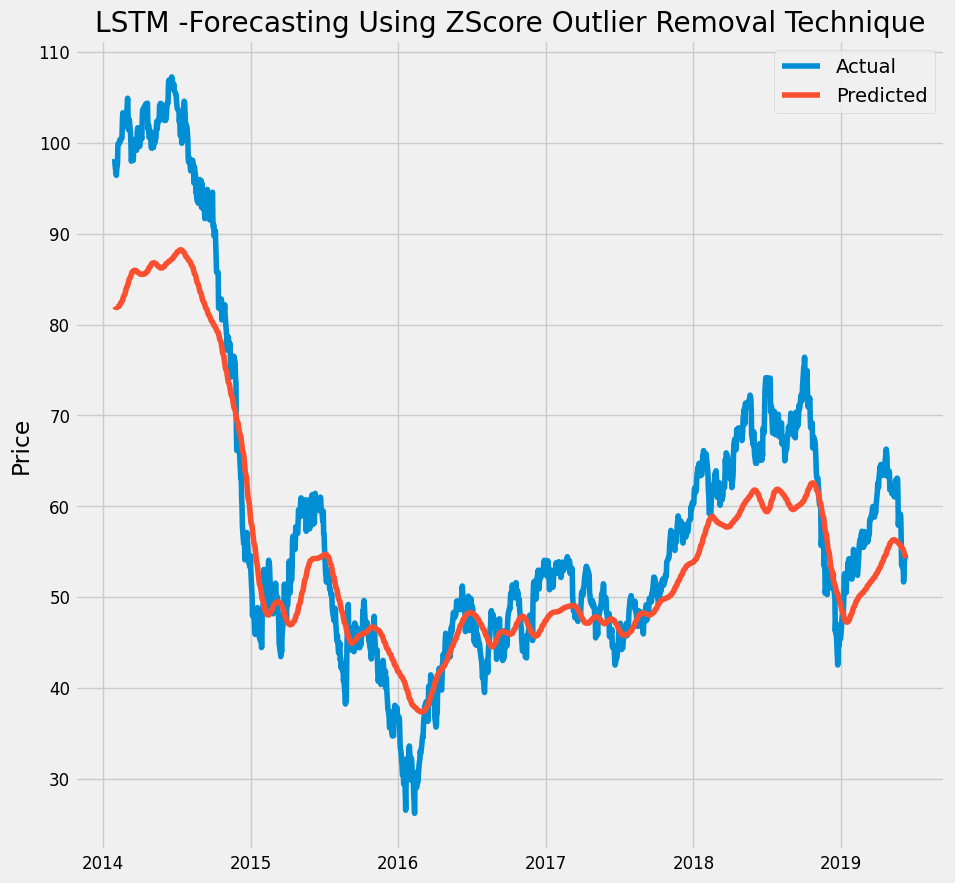

In [168]:
result_metrics_forecast(z_out_actual,z_out_pred,'LSTM','ZScore')

In [ ]:
##Forecasting For Mahalanobis Outlier Removed Dataset
lstm_model(sc1,mah_train,3)

In [ ]:
prepare_test_data_lstm(sc1,mah_test,3)

In [ ]:
predict_data(model,sc2,mah_test,X_test,'Mahalanobis Distance Outlier',3)

In [ ]:
mah_out_pred = pred_df.copy()
mah_out_actual = mah_test.iloc[61:,0].copy()

In [ ]:
result_metrics_forecast(mah_out_actual,mah_out_pred,'LSTM','Mahalanobis')

In [169]:
##Forecasting Vanilla Model-Without Outlier Removal
lstm_model(sc1,van_train,3)

Shape of Input Data Initially (3462, 3)
Shape of Train Part after transformation (3401, 60, 1, 3)
Shape of Test Part after transformation  (3401,)
Final Shape  (3401, 60, 3)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.1519
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0843
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0208
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0097
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0084
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0076
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0072
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0073
Epoch 9/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0066
Epoch 10/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0063
Epoch 11/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0064
Epoch 12/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0058
Epoch 13/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0057
Epoch 14/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0057
Epoch 15/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s

In [170]:
prepare_test_data_lstm(sc1,van_test,3)

Shape of Test Dataset (1424, 60, 3)


In [171]:
predict_data(model,sc2,van_test,X_test,'Vanilla Model',3)

45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
1424


,Predicted -Vanilla Model
0,76.985916
1,76.943153
2,76.869728
3,76.769157
4,76.646194
...,...
1419,52.727962
1420,52.588570
1421,52.432598
1422,52.259010


In [172]:
van_pred = pred_df.copy()
van_actual = van_test.iloc[61:,0].copy()

Result Metrics for LSTM -Vanilla Model-No Outlier Removal Technique
R2 Score :  0.698
Mean Squared Error :  104.786
Mean Absolute Error :  7.786


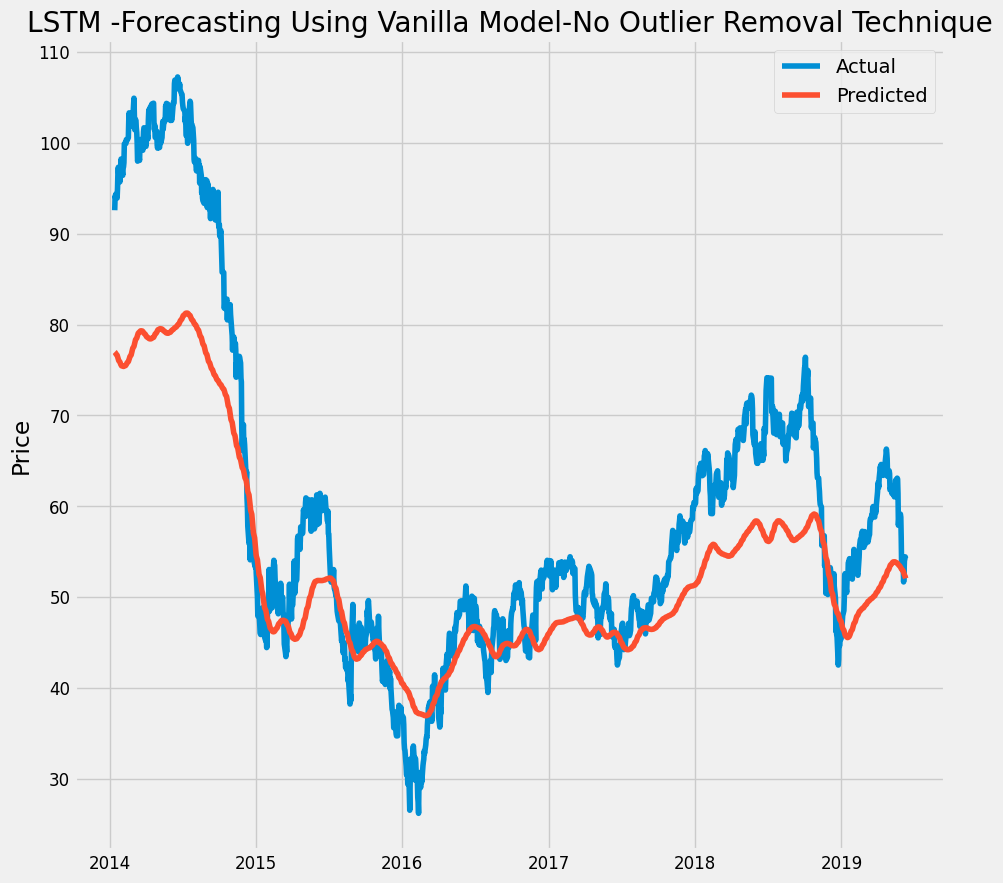

In [173]:
result_metrics_forecast(van_actual,van_pred,'LSTM','Vanilla Model-No')

NameError: name 'mah_out_actual' is not defined

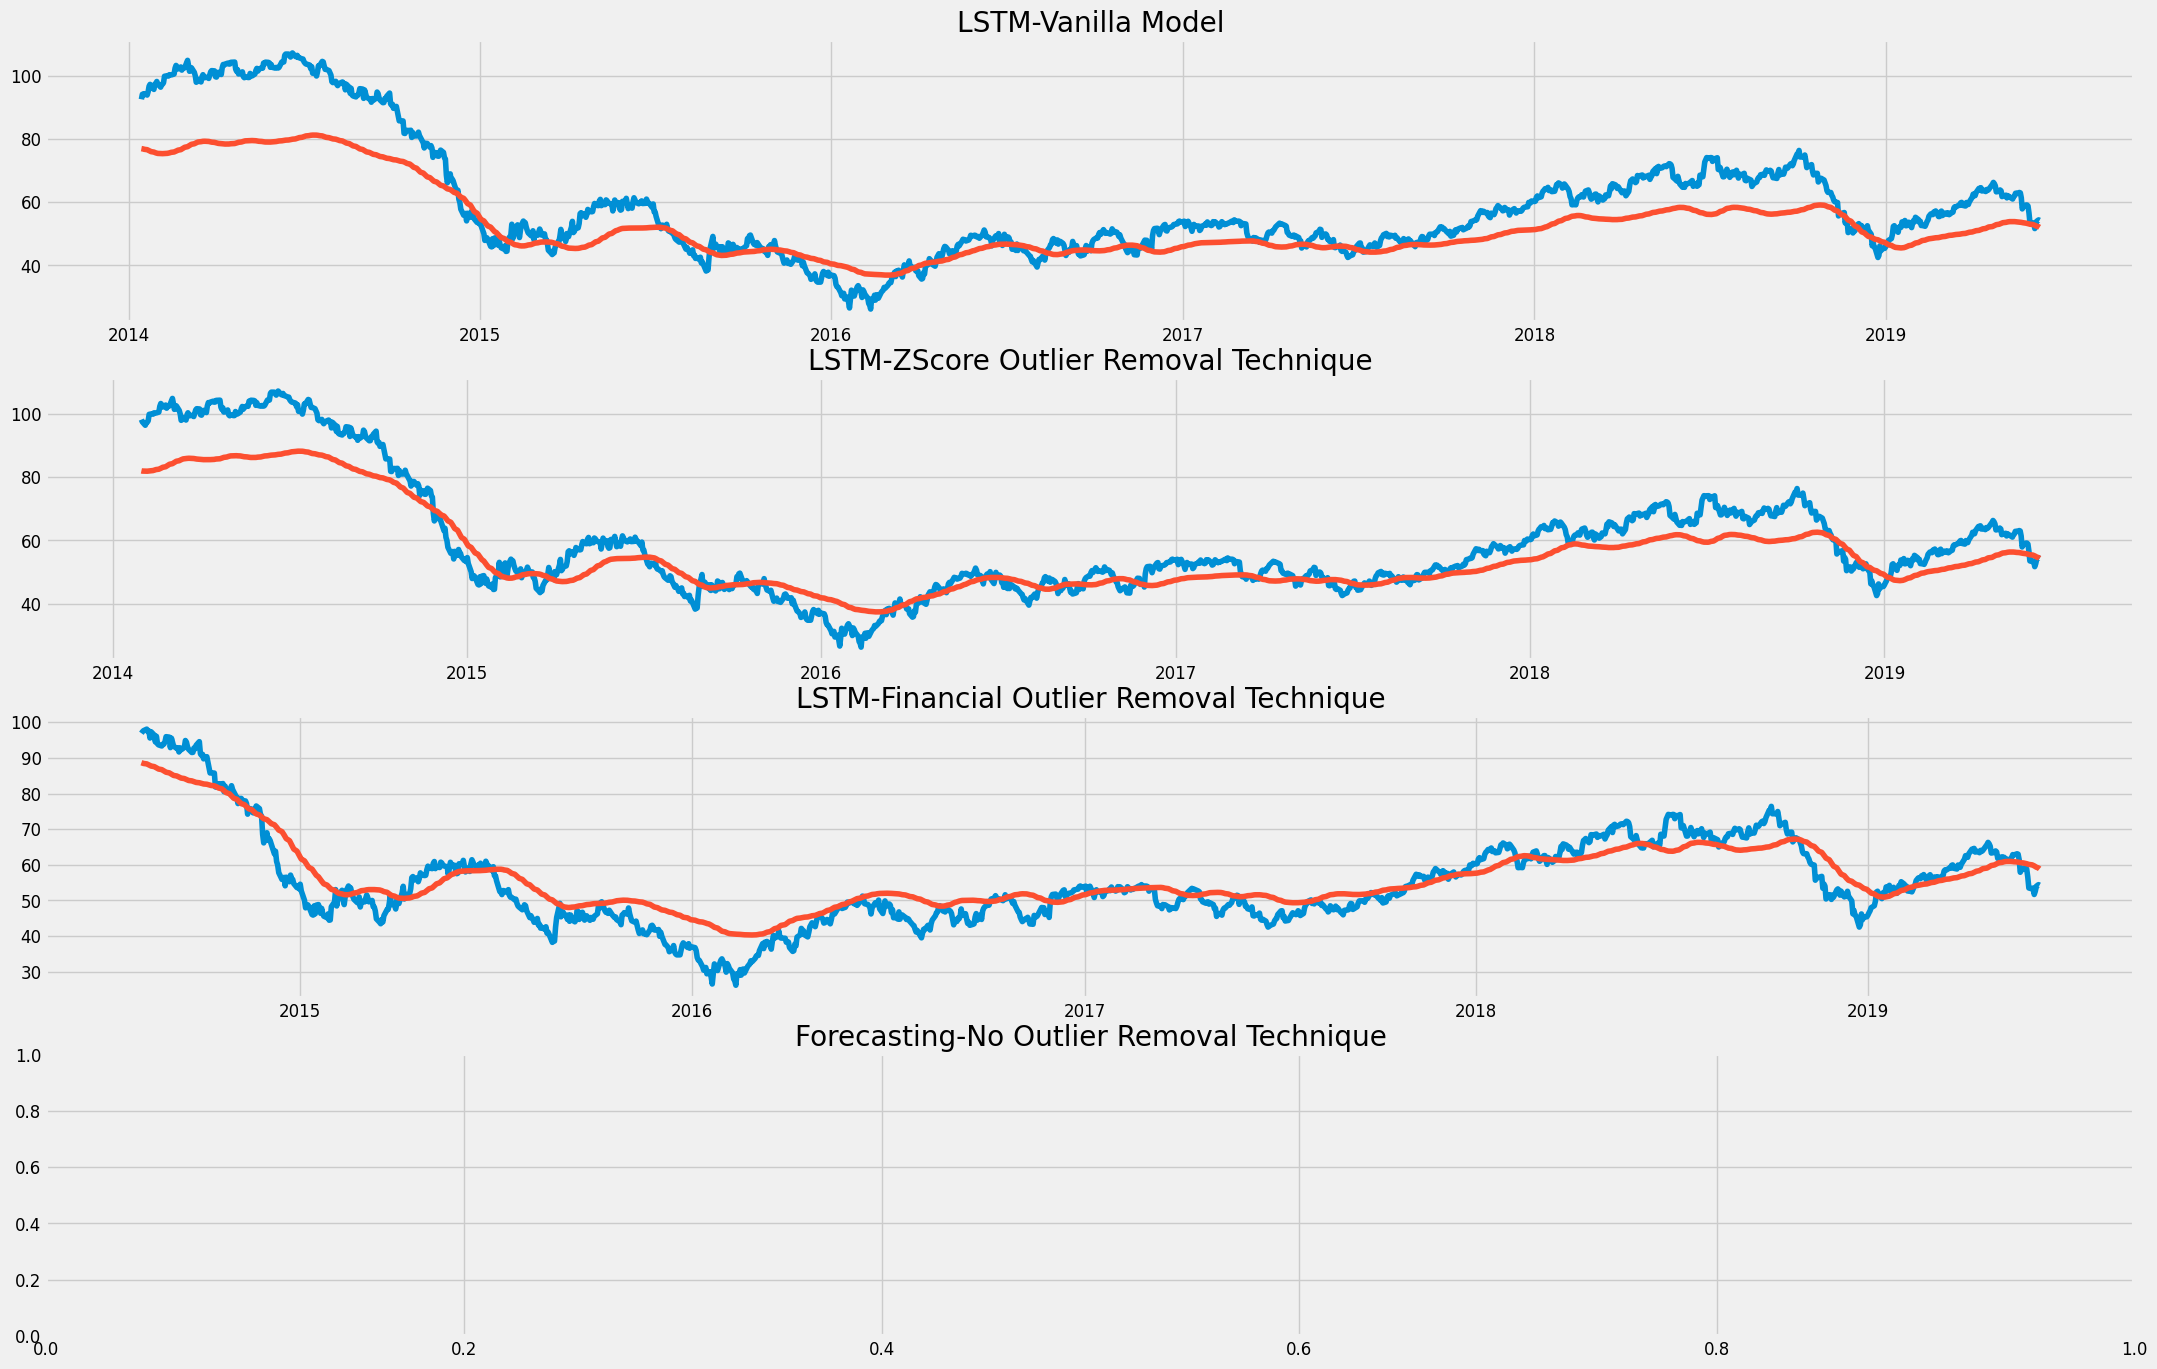

In [174]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,figsize=(24,16))

ax1.plot(van_actual.index,van_actual,label='Actual')
ax1.plot(van_actual.index,van_pred,label='Predicted')
plt.title('Forecasting-No Outlier Removal Technique')
ax1.set_title('LSTM-Vanilla Model')

ax2.plot(z_out_actual.index,z_out_actual,label='Actual')
ax2.plot(z_out_actual.index,z_out_pred,label='Predicted')
ax2.set_title('LSTM-ZScore Outlier Removal Technique')

ax3.plot(fin_out_actual.index,fin_out_actual,label='Actual')
ax3.plot(fin_out_actual.index,fin_out_pred,label='Predicted')
ax3.set_title('LSTM-Financial Outlier Removal Technique')

ax4.plot(mah_out_actual.index,mah_out_actual,label='Actual')
ax4.plot(mah_out_actual.index,mah_out_pred,label='Predicted')
ax4.set_title('LSTM-Forecasting-Mahalanobis Outlier Removal Technique')

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

plt.tight_layout(pad=3)

# Forecasting Using GRU(Gated Re-current Unit)
GRU is simply a improved version of standard Re-current Neural Network(RNN) with two gates(update & reset).

In [ ]:
#GRU Model Function
def gru_model(scaler,train_data,n_dim):
##initialize model
##GRU & LSTM use same kind of input shaped data
  prepare_train_data_lstm(scaler,train_data,n_dim)

  global gru_model
  gru_model = Sequential()

# Layer 1 of GRU with Dropout
  gru_model.add(GRU(units=30, return_sequences=True, input_shape=(X1.shape[1],n_dim), activation='tanh'))
  gru_model.add(Dropout(0.2))

# Layer 2 of GRU with Dropout
  gru_model.add(GRU(units=30, return_sequences=True, input_shape=(X1.shape[1],n_dim), activation='tanh'))
  gru_model.add(Dropout(0.2))

# Layer 3 of GRU with Dropout
  gru_model.add(GRU(units=30, return_sequences=True, input_shape=(X1.shape[1],n_dim), activation='tanh'))
  gru_model.add(Dropout(0.2))

# Layer 4 of GRU with Dropout
  gru_model.add(GRU(units=30, activation='tanh'))
  gru_model.add(Dropout(0.2))

# Output layer of GRU model
  gru_model.add(Dense(units=1))

#compiling the model
  gru_model.compile(optimizer='adam',loss='mean_squared_error')
  gru_model.fit(X1, y1, epochs=50, batch_size=32)

In [ ]:
gru_model(sc1,fin_train,3)

In [ ]:
prepare_test_data_lstm(sc1,fin_test,3)

In [ ]:
predict_data(gru_model,sc2,fin_test,X_test,'Financial Outlier',3)

In [ ]:
gru_fin_out_pred = pred_df.copy()
gru_fin_out_actual = fin_test.iloc[61:,0].copy()

In [ ]:
result_metrics_forecast(gru_fin_out_actual,gru_fin_out_pred,'GRU','Financial')

In [ ]:
##Forecasting Using Z-Score Outlier Removal
sc3 = MinMaxScaler(feature_range=(0,1))
sc4 = MinMaxScaler(feature_range=(0,1))
gru_model(sc3,z_train,3)

In [ ]:
prepare_test_data_lstm(sc3,z_test,3)

In [ ]:
predict_data(gru_model,sc4,z_test,X_test,'Z-Score Outlier',3)

In [ ]:
gru_z_out_pred = pred_df.copy()
gru_z_out_actual = z_test.iloc[61:,0].copy()

In [ ]:
result_metrics_forecast(gru_z_out_actual,gru_z_out_pred,'GRU','ZScore')

In [ ]:
sc5 = MinMaxScaler(feature_range=(0,1))
sc6 = MinMaxScaler(feature_range=(0,1))
gru_model(sc5,mah_train,3)

In [ ]:
prepare_test_data_lstm(sc5,mah_test,3)

In [ ]:
predict_data(gru_model,sc6,mah_test,X_test,'Mahalanobis Distance Outlier',3)

In [ ]:
gru_mah_out_pred = pred_df.copy()
gru_mah_out_actual = mah_test.iloc[61:,0].copy()

In [ ]:
result_metrics_forecast(gru_mah_out_actual,gru_mah_out_pred,'GRU','Mahalanobis')

In [ ]:
sc7 = MinMaxScaler(feature_range=(0,1))
sc8 = MinMaxScaler(feature_range=(0,1))
gru_model(sc7,van_train,3)

In [ ]:
prepare_test_data_lstm(sc7,van_test,3)

In [ ]:
predict_data(gru_model,sc8,van_test,X_test,'Vanilla Model',3)

In [ ]:
gru_van_pred = pred_df.copy()
gru_van_actual = van_test.iloc[61:,0].copy()

In [ ]:
result_metrics_forecast(gru_van_actual,gru_van_pred,'GRU','Vanilla Model-No')

In [ ]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,figsize=(24,16))

ax1.plot(van_actual.index,van_actual,label='Actual')
ax1.plot(van_actual.index,gru_van_pred,label='GRU Predicted',c='yellow')
ax1.plot(van_actual.index,van_pred,label='LSTM Predicted')
plt.title('Forecasting-No Outlier Removal Technique')
ax1.set_title('Vanilla Model')

ax2.plot(z_out_actual.index,z_out_actual,label='Actual')
ax2.plot(z_out_actual.index,gru_z_out_pred,label='GRU Predicted',c='yellow')
ax2.plot(z_out_actual.index,z_out_pred,label='LSTM Predicted')
ax2.set_title('ZScore Outlier Removal Technique')

ax3.plot(fin_out_actual.index,fin_out_actual,label='Actual')
ax3.plot(fin_out_actual.index,gru_fin_out_pred,label='GRU Predicted',c='yellow')
ax3.plot(fin_out_actual.index,fin_out_pred,label='LSTM Predicted')
ax3.set_title('Financial Outlier Removal Technique')

ax4.plot(mah_out_actual.index,mah_out_actual,label='Actual')
ax4.plot(mah_out_actual.index,gru_mah_out_pred,label='GRU Predicted',c='yellow')
ax4.plot(mah_out_actual.index,mah_out_pred,label='LSTM Predicted')
ax4.set_title('Mahalanobis Outlier Removal Technique')

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

plt.tight_layout(pad=3)

# **Project Summary**

**General Issues with Traditional RNN's**

Suffer from short memory due to vanishing gradients they forget initial information.

LSTM & GRU tackle short term memory problem.
They are able to regulate flow of information.

# **LSTM VS GRU**

**Long Term Short Memory(LSTM) :-**

-> Have three gates (input,output & forget gate)

-> More memory consumption and more training time in comparision to GRU.

-> With Bigger datasets LSTM is better suited.

**Modelling Results LSTM :-**

Mahalanobis Distance Outlier Removal (R2 Score): 0.934

Financial Outlier Removal (R2 Score): 0.918

Z-Score Outlier Removal (R2 Score): 0.898

Vanilla Model-No Outlier Removal(R2 Score): 0.728

**Gated Re-current Unit(GRU) :-**

-> Have two gates (reset & update gate)

-> Less memory consumption, faster execution, less training time.

-> More suited for smaller datasets.

**Modelling Results GRU :-**

Mahalanobis Distance Outlier Removal (R2 Score): 0.946

Financial Outlier Removal (R2 Score): 0.915

Z-Score Outlier Removal (R2 Score): 0.901

Vanilla Model-No Outlier Removal(R2 Score): 0.706


**Best Outlier Elimination Method :-**

-> In both LSTM & GRU , the order of performance remains same .

->Mahalanobis Distance as outlier removal is the best techique among all we tested.


**Best to worst performing model**

**Mahalanobis Outlier Removal > Financial Outlier Removal > Z-Score Outlier Removal > No Outlier Removal**

# **Overall Verdict :-**

-> Both LSTM & GRU are very capable for long sequential prediction problems.
Both can be handy according to the type of problem .

-> In our forecasting we observed both being very close at predicting and there is no clear winner.
